In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/ok_pan_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [4]:
original_feature_path = './data/form/landforms_10classes_30m_dd83.img'

feature_file = rasterio.open(original_feature_path)
feature_raster = feature_file.read(1)

In [5]:
dst_crs = rasterio.crs.CRS.from_epsg(3857)

In [6]:
transform, width, height = rasterio.warp.calculate_default_transform(
    feature_file.crs, dst_crs, feature_file.width,
    feature_file.height, *feature_file.bounds)
kwargs = feature_file.meta.copy()
kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

dst = './data/form/landforms_10classes_30m_dd83_3857.tiff'

with rasterio.open(dst, 'w', **kwargs) as dst:
    rasterio.warp.reproject(
        source=rasterio.band(feature_file, 1),
        destination=rasterio.band(dst, 1),
        src_transform=feature_file.transform,
        src_crs=feature_file.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=rasterio.warp.Resampling.nearest)

In [4]:
feature_path = './data/cover/landforms_10classes_30m_dd83_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [5]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
27.0,-1.146618e+07,4.413429e+06,-1.146518e+07,4.412429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4413429.055, -11465176...",3
28.0,-1.146618e+07,4.412429e+06,-1.146518e+07,4.411429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4412429.055, -11465176...",3
29.0,-1.146618e+07,4.411429e+06,-1.146518e+07,4.410429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4411429.055, -11465176...",3
30.0,-1.146618e+07,4.410429e+06,-1.146518e+07,4.409429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4410429.055, -11465176...",3
31.0,-1.146618e+07,4.409429e+06,-1.146518e+07,4.408429e+06,-120.000,0,1,"POLYGON ((-11466176.166 4409429.055, -11465176...",2
...,...,...,...,...,...,...,...,...,...
23376.0,-1.113318e+07,4.374429e+06,-1.113218e+07,4.373429e+06,-106.920,1,1,"POLYGON ((-11133176.166 4374429.055, -11132176...",3
23377.0,-1.113318e+07,4.373429e+06,-1.113218e+07,4.372429e+06,-109.290,1,1,"POLYGON ((-11133176.166 4373429.055, -11132176...",2
23378.0,-1.113318e+07,4.372429e+06,-1.113218e+07,4.371429e+06,-107.125,1,1,"POLYGON ((-11133176.166 4372429.055, -11132176...",10


In [6]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [7]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [21]:
confusion_matrix = pd.crosstab( grid['feature'],grid['agreement'], rownames=['Form Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement     False     True 
Form Type                    
1          0.797944  0.202056
2          0.773503  0.226497
3          0.757390  0.242610
4          0.500000  0.500000
6          0.500000  0.500000
7          0.000000  1.000000
10         0.764820  0.235180


In [22]:
confusion_matrix['Total'] = grid.groupby('feature').count()['agreement']

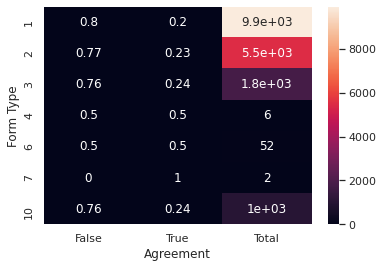

In [23]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement   False  True    All
Cover Type                    
1            7918  2005   9923
2            4262  1248   5510
3            1358   435   1793
4               3     3      6
6              26    26     52
7               0     2      2
10            787   242   1029
All         14354  3961  18315


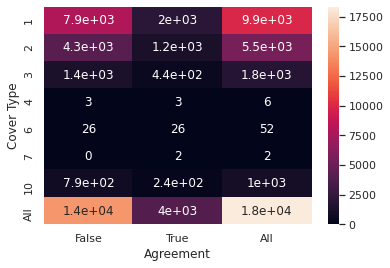

In [17]:
confusion_matrix = pd.crosstab( grid['feature'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()